<a href="https://colab.research.google.com/github/wobiero/Madagascar-CEA/blob/main/mada_mccm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Economic Analysis CHV Madagascar

**Key items:**
- Estimate costs for treating case of uncomplicated malaria by CHVs
- Estimate budget impact of the expanded CHV program
- Estimate economic impact of expanded CHV program
- Breakeven analysis for potential CHV compensation

**Substitution of point of care effects**
- Increased workload for non-compensated CHVs - increased churn
- Early treatment for uncomplicated malaria - reduced progression to severe disease and mortality
- Reduced workload at health facilities - both for severe and uncomplicated malaria
- Reduced workload and potential increase in quality of care for those who access clinics/hospitals. Paradoxical increase in attendance for patients living close to health facilities.


**Issues in estimating substitution effects of the new program**
- Length of average malaria episode -- Assume this is a function of distance from facility and sub-optimal care
- Sub-optimal care represents either misdiagnosis or improper dosing
- Estimation of loss of income at home for informal care
- Estimation of transport costs
- Estimation of alternative care before coming to facilities
- Estimated value of future earnings from premature deaths avoided
- Family time costs measured using an opportunity cost approach
- Proportion of facility cases as malaria
- Proportion of facility cases that will shift to CHV care as a function of distance and acceptability of CHVs
- Proportion of home cases that will shift to CHV care as a function of distance
- Cost of care from informal sector or private clinics
- Potential change in severe malaria cases
- Malaria mortality changes
- Reduction in malaria probability due to expanded treatment
- RDT positivity rate for CHVs versus RDT positivity rate for formal healthcare workers (for estimating differential usage) -- get values for Mada
- Rate treated with RDT for clinical diagnosis versus rate treated following positive RDT
- Total time spent at facility
- Time motion studies for IPTI  12.4 (1.6 - 28.9min): https://pubmed.ncbi.nlm.nih.gov/18823639/
- Are there differential complication rates between the two study arms


In [ ]:
# Import libraries for the analyses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib.ticker import StrMethodFormatter
import scipy.stats as stats
from scipy.stats import gamma, invgamma, norm, skellam
from dataclasses import dataclass

<u>**Cost Data** </u>

- Cost data cannot be negative.
- Therefore normal distribution is inappropriate (-$\infty$ to +$\infty$).
- Beta is also inappropriate since it has a maximum value of 1.
- Healthcare costs typically cluster around the mode with a few extreme values (long-tailed).
- Ideal distributions - LogNormal and Gamma. Will use Gamma here.

In [ ]:
# We will use gamma distributions primarily for costs
# We will make adjustments to calculate alphas and betas from mean and sd
# Make a function to make this non-repetitive

def gamma_stats(mean, std_dev, size=1000):
    """
    Generate mean and 95% confidence interval for a gamma distribution based on given mean and standard deviation parameters.

    Parameters:
        mean (float): Mean of the distribution.
        std_dev (float): Standard deviation of the distribution.
        size (int): Number of samples to generate (default is 1000).

    Returns:
        tuple: Tuple containing mean and 95% confidence interval.
    """
    # Calculate shape (alpha) and scale (beta) parameters
    alpha = (mean / std_dev) ** 2
    beta = (std_dev ** 2) / mean

    # Generate gamma distribution
    simulated_data = np.random.gamma(alpha, beta, size=size)

    # Calculate mean and 95% confidence interval
    mean_value = np.mean(simulated_data)
    confidence_interval = np.percentile(simulated_data, [2.5, 97.5])

    return mean_value, confidence_interval, simulated_data


In [ ]:
#Key constants for the analyses
exchange_rate = 3905.54 # To USD
discount_rate = .03
wastage_rate = 1.05 # Based on data from the field (5%)
# The wastage rate may need to be adjusted to reflect expiry

In [ ]:
# RDT Consumable Costs
# Discuss with team if face masks and alcohol handrub are used
# Are face masks reused
rdt = 1.05 * (1.1)# Per kit - PSM Assumes 10% wastage for RDTs
gloves = 0.119 * 2 * wastage_rate # Breakdown rate of 1% given in spreadsheet
lancet = 0.03995 # 200 @ $7.99
alcohol_swabs = 0.055 * 2 * wastage_rate # Assume two per patient $5.50 for 200
safety_box = 0.0384 * 2 # We assume that a safety box is used for 50 patients. Hard to carry around.
hand_rub = 0.0262 # $2.62 for a 500 ml bottle. Assume two pump dispenser push or 2.4ml. Assume two uses per client
face_mask = 0.06 * wastage_rate #Assume current patterns

In [ ]:
total_rdt = rdt + gloves + lancet + alcohol_swabs + safety_box + hand_rub + face_mask
print(f"""The estimated total costs for RDT consumables is ${total_rdt:,.2f}.
These costs do not include waste disposal costs of ~ 15%.
We assume transport costs are already included in the costs.""")

The estimated total costs for RDT consumables is $1.73. 
These costs do not include waste disposal costs of ~ 15%. 
We assume transport costs are already included in the costs.


Handrub use assumption:
- Less and less influence of volume on hand coverage and bactericidal efficacy in handwashing. [Kampf et al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3851816/#:~:text=Some%20manufacturers%20recommend%20using%201.1,current%20efficacy%20standards%20is%20unknown)

In [ ]:
number_of_chws = 502 # From study
consultations = 462_215 # From Study
# Costs are in Ar. Will adjust below to USD
trainer_per_diem = 5_690_000
trainer_salary = 7_884_356 # Government or donors pay for the trainers wages, which should be included .
# These can be omitted if training is done by consultants and captured as such
chw_per_diem = 50_200_000
facility_incharge_per_diem = 1_500_000
refreshments = 333_000
hall_rental = 950_000
transport = 3_556_681.8
printing = 805_000

# Calculate total initial training cost
total_initial_training = (trainer_per_diem + chw_per_diem +
                          facility_incharge_per_diem +
                          refreshments + hall_rental + transport +
                          printing)/exchange_rate

# Assume standard deviation is 20% of the values
std_deviation = 0.2 * total_initial_training

# Number of Monte Carlo simulations
n_simulations = 1000

# Run gamma simulation and return values
g_values = gamma_stats(total_initial_training, std_deviation)
mean_init = g_values[0]
print(f"Mean initial training costs: ${g_values[0]:,.2f}")
print(f"95% Confidence Interval: $[{g_values[1][0]:,.2f}, {g_values[1][1]:,.2f}]")
print("The CI are for national projection purposes. Will use actual mean for the analysis.")


Mean initial training costs: $16,064.79
95% Confidence Interval: $[10,481.09, 22,985.84]
The CI are for national projection purposes. Will use actual mean for the analysis.


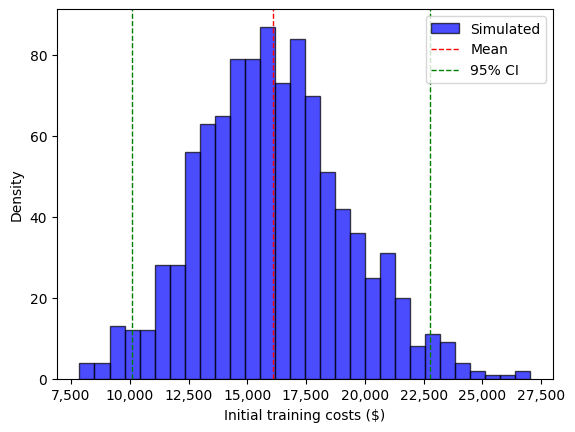

In [ ]:
plt.hist(g_values[2], bins=30, alpha=.7, color="b", ec="k", label="Simulated")
plt.axvline(x=np.mean(g_values[2]), color="r", linestyle="--", lw=1, label="Mean")
plt.axvline(x=g_values[1][0], color="g", linestyle="--", lw=1, label="95% CI")
plt.axvline(x=g_values[1][1], color="g", linestyle="--", lw=1)
plt.ylabel("Density")
plt.xlabel("Initial training costs ($)")
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.legend();

**Refresher training**
- These were much higher than the initial training costs in the spreadsheet
- Might be an error
- Will peg them at 80% initial training costs but can adjust this

In [ ]:
per_diem_chv = 50_200_000
per_diem_trainer = 6_144_000
facility_incharge_per_diem = 1_500_000
refreshments = 3_625_000
hall_hire = 2_160_000
transport = 5_497_800
printing = 805_000
ref_adjustment = .8
tot_refresher = (per_diem_chv + per_diem_trainer +
                 facility_incharge_per_diem + refreshments +
                 hall_rental + printing + transport)/exchange_rate
refresher_sd = .2 * tot_refresher
ref_values = gamma_stats(tot_refresher, refresher_sd)
mean_ref = ref_values[0]
print(f"Mean refresher training costs: ${mean_ref:,.2f}")
print(f"95% Confidence Interval: $[{ref_values[1][0]:,.2f}, {ref_values[1][1]:,.2f}]")
print("The CI are for national projection purposes. Will use actual mean for the analysis.")


if mean_ref > g_values[0]:
  mean_ref *= ref_adjustment
  print(f"We will use a mean refresher value of ${mean_ref:,.2f}")


Mean refresher training costs: $17,548.43
95% Confidence Interval: $[10,990.55, 24,843.35]
The CI are for national projection purposes. Will use actual mean for the analysis.
We will use a mean refresher value of $14,038.74


**Community sensitization costs**
- These are one-off costs
- Initial costs based on 15 health facilities
- Will be scaled to reflect 30 facilities

In [ ]:
# Community sensitization costs for ICCM
# Assumes 4 days of sensitization for 15 facilities
sensitization = 4_873_600 * 2/ exchange_rate
print(f"Community sensitization costs were ${sensitization:,.2f}")
sensitization_per_chw = sensitization/number_of_chws
print(f"Average sensitization costs per CHW were ${sensitization_per_chw:,.2f}")


Community sensitization costs were $2,495.74
Average sensitization costs per CHW were $4.97


In [ ]:
# Planning meetings (one off costs)
strategic_planning_national = 12_517_420 # (4 days for 40 participants)
district_share_national = strategic_planning_national/40
strategic_planning_district = 17_064_800 + district_share_national # (5 days for 30 participants
strategic_planning_chv = strategic_planning_district/number_of_chws
print(f"District planning costs: ${strategic_planning_district/exchange_rate:,.2f}")
print(f"CHV share of strategic planning costs per CHV ${strategic_planning_chv/exchange_rate:,.2f}")
print("=========================================================================")
print("The CHV share will be split across all patients seen")
print("We will not annualize planning costs.")

District planning costs: $4,449.51
CHV share of strategic planning costs per CHV $8.86
The CHV share will be split across all patients seen
We will not annualize planning costs.


In [ ]:
# Estimate population size with malaria
# Estimate population reached with treatment
# Estimate population effectively treated
# Estimate differential number of deaths
# Estimate DALY's averted
# Average visit time [simulate around a range of values]
# Average number of daily visits [range and standard deviation]
# Assume that deaths occur only in under 5
# Life expectancy at birth - 65.3 years
#Inputs
median_age = 20.3
inequality_quintile = .057
lower_ppp_ce_threshold = 28 # International dollars
upper_ppp_ce_threshold = 717 # International dollars
hourly_wage_ppp = .75
hourly_wage_nominal = .19
gdp_ppp = 1601 #International dollars
gdp_per_capita = 516.59
work_week = 40 # 40 hours
inflation_official = 6.0 # Inflation rate percentage
cases_per_thousand = 32.04 # Malaria Atlas Project (Andres to confirm)
infection_prevalence = 2.75 # Per 100 children Malaria Atlas Project
mortality_rate = 9.62 # Per 100,000 Malaria Atlas Project

In [ ]:
# Years lived with disability
# Number of incident cases
# Average duration of a case
# Disability weight
# Wastage is a parameter that can be adjusted to include stockouts.
# Change service utilization to reflect what the study found. For example, RDT can increase to 100% if home-based services given.
# Alternatively use mean values from the study
adherence = .808 # Adjust accordingly
wastage = .15 # Adjust accordingly
utilization = 1 # Can adjust service utilization instead and maintain efficacy levels as constant (unless multiplicative)
mal_in_fever = .3481 # proportion of malaria in cases with fever [Consult and change accordingly]
efficacy_no_prog = .748
efficacy_prog = .9195
proportion_severe = .082 # Proportion of malaria cases that are severe
cfr = 1.371e-02
protection = (100 - wastage) * utilization * adherence
cases_averted_no_prog = protection * mal_in_fever * efficacy_no_prog * proportion_severe
cases_averted_prog = protection * mal_in_fever * efficacy_prog * proportion_severe
deaths_averted_no_prog = protection * cfr * efficacy_no_prog * mal_in_fever
deaths_averted_prog = protection * cfr * efficacy_prog * mal_in_fever

In [ ]:
# Estimate discounted future life years saved for each death averted
life_expectancy = 65.3 # Life expectancy at birth
avg_age_death = 2.5 # assume average age of death
discounted_future_years = np.sum([1/(1 + discount_rate)**t for t in list(range(int(life_expectancy - avg_age_death)))])
print(f"The average discounted years lived per death averted is: {discounted_future_years:,.2f} years")
print("This value will be used in estimating economic benefits of each death averted")

The average discounted years lived per death averted is: 28.84 years
This value will be used in estimating economic benefits of each death averted


498329.1508773225
3983.5949437772315


**Value of statistical life**
This will be used to estimate the mortality prevention benefits.

Net Present Value of a life lost in Madagascar: $12016.22


**Estimation of economic value of donated time**
- The average consultation time is a function of whether RDT tests are offered or not
- Unlike in health facilities where activities are done in parallel, for CHVs we assume that activities are done serially.
- That is, a CHV's consultation time per patient will be much longer as they have to wait at the home until an RDT is run.
- The CHVs may offer other services like health promotion at this time, but these will not be valued.
- As such, CHV time should be seen as an over-estimate.
- We will conduct sensitivity analyses around this value.

In [ ]:
def chv_clinical_time(consult_time, consultations_per_year, rdt_adjustment, hourly_wage_nominal):
  tot_time = (consult_time/60) * consultations_per_year * rdt_adjustment
  avg_cost = tot_time * hourly_wage_nominal
  return tot_time, avg_cost

consult_time = 45.7 # This includes clerking, running RDT, dispensing, health promotion
consultations_per_year = 464_440/number_of_chws
rdt_adjustment = .8 # Proportion of all reviews that get RDT
clinical_time, clin_time_cost = chv_clinical_time(consult_time,
                                                  consultations_per_year,
                                                  rdt_adjustment, hourly_wage_nominal)
donated_time = gamma_stats(clin_time_cost, clin_time_cost * .2)
average_cost = donated_time[0]
lower_bound = donated_time[1][0]
upper_bound = donated_time[1][1]
print(f"Estimated Average Economic Cost of CHV time per year: ${average_cost:,.2f}")
print(f"95% CI: $[{lower_bound:,.2f}, {upper_bound:,.2f}]")
print("=========================================================================")
print("These costs do not cover travel to home, facility, or reporting time.")
print("=========================================================================")

Estimated Average Economic Cost of CHV time per year: $106.68
95% CI: $[69.48, 151.95]
These costs do not cover travel to home, facility, or reporting time.


**CHV Non-Clinical Time Costs**
- Assume 15-minute walk one way to home
- Assume 1 visit monthly to health facility for meetings, supplies, reports
- Monthly meeting plus travel pegged at 6 hours
- Assume 1 hour per week on reports, notes, drug reconciliations
- The 30-minute return trip assumption is conservative.
- Andres to confirm plausibility of these assumptions
- Senior author: [Improving geographical accessibility modeling for operational use by local health actors](https://link.springer.com/article/10.1186/s12942-020-00220-6)
- Senior author: [Geographic barriers to care persist at the community healthcare level: Evidence from rural Madagascar.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10022327/)


In [ ]:
travel_pt_visit = 464_440/number_of_chws * 30/60
facility_travel = 6 * 12
report_time = 4 * 12
tot_extra_time = travel_pt_visit + facility_travel + report_time
non_clin_time_cost = hourly_wage_nominal * tot_extra_time
print("================================================================")
print(f"Estimated non-clinical time per year: {tot_extra_time:,.1f} hours")

assoc_time_cost = gamma_stats(non_clin_time_cost, non_clin_time_cost * .2)
lower_bound = assoc_time_cost[1][0]
upper_bound = assoc_time_cost[1][1]
print("================================================================")
print(f"Non-clinical time costs per year: ${non_clin_time_cost:,.2f}")
print(f"95% CI: $[{lower_bound:,.2f}, {upper_bound:,.2f}]")
print("================================================================")

Estimated non-clinical time per year: 582.6 hours
Non-clinical time costs per year: $110.69
95% CI: $[73.93, 156.48]


**Note:**
- Non-clinical time in the analysis above is higher than actual clinical time
- Based on time alone, economic costs per CHV are : $$217.37 per annum
- This was estimated using nominal GDP values
- If we use GDP purchasing power parity, this rises to $858.04 per annum
- Note the assumptions around consult time and travel time

In [ ]:
# Mortality benefits
# Verify with team if there are any mortality benefits
def calculate_npv(mean_age_of_death, life_expectancy, discount_rate, gdp_per_capita):
    years_of_life_lost = life_expectancy - mean_age_of_death
    npv = 0

    for year in range(1, years_of_life_lost + 1):
        discounted_value = gdp_ppp / ((1 + discount_rate) ** year)
        npv += discounted_value

    return npv

# Given parameters
median_age_of_death = int(19.3)
life_expectancy = int(67.8)
discount_rate = 0.03  # 3%
mean_age_work = 15
# Calculate NPV -- this assumes that the mean age of economic productivity is 15
# Some economists use 12 years

result_1 = calculate_npv(median_age_of_death, life_expectancy, discount_rate, gdp_ppp)
result_2 = calculate_npv(median_age_of_death, (mean_age_work - median_age_of_death), discount_rate, gdp_ppp)
print("================================================================")
print(f"Net Present Value of a life lost in Madagascar: ${result_1 - result_2:.2f}")
print("================================================================")

Net Present Value of a life lost in Madagascar: $40452.00


**Estimating mortality averted benefits using VSL**
- Approach used outlined in this paper
- Income elasticities and global values of a statistical life. [Viscusi & Masterman 2017](https://www.cambridge.org/core/journals/journal-of-benefit-cost-analysis/article/income-elasticities-and-global-values-of-a-statistical-life/5AE299883F668DCC265C41A377E1E063)

Formula:

$$ VSL_{M} = VSL_{US} * \left(\frac{GDP.PPP_{M}}{GDP.PPP_{US}}\right)^{\epsilon} $$

Where: $\epsilon$ = income elasticity

While the paper above uses an eta of 1.0, we follow [Robinson et al. 2019](https://www.cambridge.org/core/journals/journal-of-benefit-cost-analysis/article/valuing-mortality-risk-reductions-in-global-benefitcost-analysis/71252D2A48B3F2402DF209550C1945FA) and use an $\epsilon$ of 1.5

In [ ]:
# Use US values as baseline
us_gdp_pc = 76_329.58 # World Bank 2022
gdp_ratio = gdp_per_capita/us_gdp_pc
eta = 1.5 # Income elasticity Madagascar
life_expectancy = 67.8
median_age = 19.3
rem_life = int(life_expectancy - median_age)
us_vsl = 11_377_977 # USDA values 2022
mada_vsl = us_vsl * (gdp_ppp/us_gdp_pc) ** eta

# Robinson et al recommend using 20 times GNI if VSL lower than GNI per capita
if mada_vsl > gdp_ppp * 20:
  pass
else:
  mada_vsl = gdp_ppp * 20
print("================================================================")
print(f"The estimated VSL for Madagascar is: ${mada_vsl:,.2f}")
print("================================================================")
# Estimate VSL per year Madagascar
vsl_year_mada = mada_vsl/np.sum([(1+discount_rate) ** -t for t in range(rem_life)])
print(f"Annualized VSL Madagascar: ${vsl_year_mada:,.2f}")
print("================================================================")
print("Note the values from the NPV approach are $6K greater than VSL.")
print("We will use the more conservative VSL figures.")

The estimated VSL for Madagascar is: $34,563.10
Annualized VSL Madagascar: $1,328.09
Note the values from the NPV approach are $6K greater than VSL.
We will use the more conservative VSL figures.


Note:
Impact of the program can be estimated by multiplying DALYs by VSL per year

## Estimate patient level time costs with and without program
- Estimate number of sick days averted
- This is from progression to severe disease as well as days sick untreated
- Adjust each year VSL by economic growth rate (values from IMF)


## National level estimates from World Malaria Report 2022

| Indicator | Mean | Lower| Upper |
|:----------|------|-------|------:|
|Cases | 3559518| 2269000| 4940000|
|Deaths| 9111| 3510 |17000 |
|Progression | .02 |.01 |.03|

- Progression refers to uncomplicated cases that become severe.
- The CHV expansion reduces this progression

**Other assumptions**

IRR values. Zambia study.

|Indicator | Mean | Range | Source |
|:---------|------|-------|-------:|
|*Admission reduction | .81| [.75, .87], p.002|[Ashton](https://pubmed.ncbi.nlm.nih.gov/36927440/)|
|*Deaths reduction | .77| [.66, .91], p<.001|[Ashton](https://pubmed.ncbi.nlm.nih.gov/36927440/)|
|Admission reduction | .84| [.78, .90], p<.001 |[Ashton](https://pubmed.ncbi.nlm.nih.gov/36927440/)|
|Deaths reduction | .78| [.68, .89], p<.001|[Ashton](https://pubmed.ncbi.nlm.nih.gov/36927440/)|

Starred (*) refer to under-5

In [ ]:
# To verify numbers with Andres
# Will use these proportions to adjust the Madagascar values
malaria_cases_mean = 3_559_518
malaria_cases_lower = 2_269_000
malaria_cases_upper = 4_940_000
uncomplicated_severe_lower = .01 # World Malaria report
uncomplicated_severe_mean = .02 # Uncomplicated cases that become severe
uncomplicated_severe_upper = .03
severe_hospitalized = .65 # 50-80% of severe cases
reduction_admission_chv = .16 # IRR .84[.78-.90, p<.001] https://pubmed.ncbi.nlm.nih.gov/36927440/
reduction_mortality_chv = .22 # IRR .78[.68-.89, p<.001] https://pubmed.ncbi.nlm.nih.gov/36927440/
malaria_deaths_mean = 9_111
malaria_deaths_lower = 3_510
malaria_deaths_upper = 17_000
# Source -- World Malaria Report 2023
deaths_averted_chv = .19  # Under 5 data https://pubmed.ncbi.nlm.nih.gov/36927440/

In [ ]:
lower_range_mal = malaria_cases_lower/malaria_cases_mean
upper_range_mal = malaria_cases_upper/malaria_cases_mean
lower_range_death = malaria_deaths_lower/malaria_deaths_mean
upper_range_death = malaria_deaths_upper/malaria_deaths_mean

In [ ]:
.02*3559518

71190.36

In [ ]:
# Define test characteristics
sensitivity_mt = 0.99
specificity_mt = 0.95
sensitivity_st = 0.90
specificity_st = 0.95

# Define disease and treatment parameters
disease_prevalence = 0.01
treatment_success_rate = 0.8

# Calculate probabilities for each outcome
# True positive (TP)
tp_mt = disease_prevalence * sensitivity_mt
tp_st = disease_prevalence * sensitivity_st

# False positive (FP)
fp_mt = (1 - disease_prevalence) * (1 - specificity_mt)
fp_st = (1 - disease_prevalence) * (1 - specificity_st)

# True negative (TN)
tn_mt = (1 - disease_prevalence) * specificity_mt
tn_st = (1 - disease_prevalence) * specificity_st

# False negative (FN)
fn_mt = disease_prevalence * (1 - sensitivity_mt)
fn_st = disease_prevalence * (1 - sensitivity_st)

# Define costs
cost_mt = 100  # Cost per multiplex test
cost_st = 50  # Cost per single test
treatment_cost = 1000  # Cost of treatment

# Calculate expected costs per test
expected_cost_mt = (tp_mt + fp_mt) * cost_mt + (fn_mt + tn_mt) * treatment_cost
expected_cost_st = (tp_st + fp_st) * cost_st + (fn_st + tn_st) * treatment_cost

# Calculate expected positive years of life saved (PYLS)
pyls_mt = tp_mt * treatment_success_rate
pyls_st = tp_st * treatment_success_rate

# Calculate incremental cost-effectiveness ratio (ICER)
icer = (expected_cost_mt - expected_cost_st) / (pyls_mt - pyls_st)

# Print results
print("Expected cost per test (MT):", expected_cost_mt)
print("Expected cost per test (ST):", expected_cost_st)
print("Expected PYLS per test (MT):", pyls_mt)
print("Expected PYLS per test (ST):", pyls_st)
print("ICER:", icer)

<ipython-input-3-20ac06fd28ea>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["$0", "$10", "$20", "$30", "$40", "$50"])


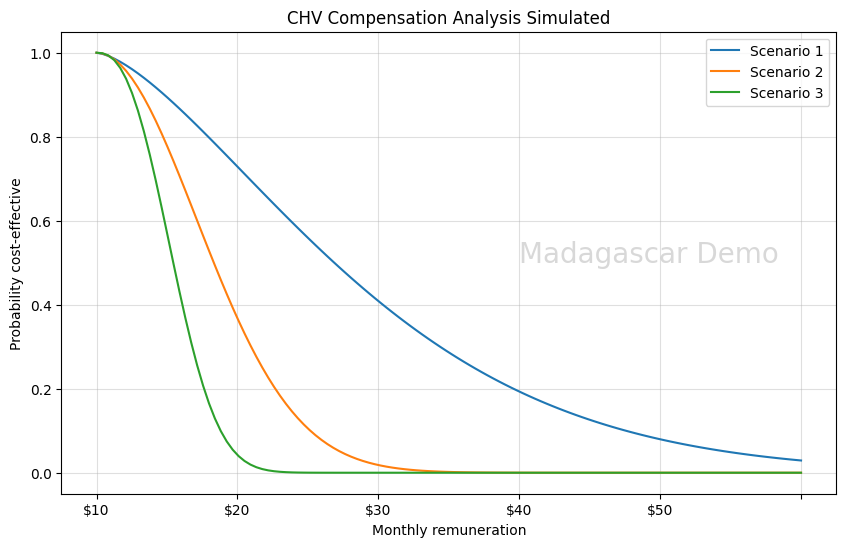

In [ ]:
decay_rate = 0.01
time = np.linspace(0,50,120)
initial_value = 1.0


quadratic_1_decay_function = initial_value * np.exp(-decay_rate * time**1.5)
quadratic_2_decay_function = initial_value * np.exp(-decay_rate * time**2.0)
quadratic_3_decay_function = initial_value * np.exp(-decay_rate * time**2.5)
#sigmoid_decay_function = initial_value/ (1 + np.exp(decay_rate * (time - 25)))
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(time, quadratic_1_decay_function, label="Scenario 1")
plt.plot(time, quadratic_2_decay_function, label="Scenario 2")
plt.plot(time, quadratic_3_decay_function, label="Scenario 3")
plt.legend(loc="best")
plt.text(30, 0.5, "Madagascar Demo", color="gray", alpha=.3, fontsize=20)
plt.ylabel("Probability cost-effective")
plt.xlabel("Monthly remuneration")
plt.title("CHV Compensation Analysis Simulated")
ax.set_xticklabels(["$0", "$10", "$20", "$30", "$40", "$50"])
plt.grid(axis="both", alpha=.4)

In [ ]:
# Breakeven point estimates
def calculate_gini(sigma):
    """
    Calculate the Gini coefficient from the standard deviation (σ).

    Parameters:
        sigma (float): The standard deviation (σ) of the log-normal distribution.

    Returns:
        float: The Gini coefficient of the distribution.
    """
    return 2 * stats.norm.cdf(sigma / np.sqrt(2)) - 1

def calculate_mu_sigma(average_income, gini_coefficient):
    """
    Calculate μ and σ of the log-normal distribution from average income (E(Y)) and Gini coefficient (G).

    Parameters:
        average_income (float): The average income (E(Y)) of the log-normal distribution.
        gini_coefficient (float): The Gini coefficient (G) of the distribution.

    Returns:
        tuple: A tuple containing μ and σ.
    """
    sigma = np.sqrt(2 * stats.norm.ppf((gini_coefficient + 1) / 2))
    mu = np.log(average_income) - (sigma ** 2) / 2
    return mu, sigma

def calculate_household_income(mu, sigma, p):
    """
    Calculate household income at a given quantile (p) using the log-normal distribution.

    Parameters:
        mu (float): The parameter μ of the log-normal distribution.
        sigma (float): The parameter σ of the log-normal distribution.
        p (float): The quantile value.

    Returns:
        float: Household income at the specified quantile.
    """
    u_p = stats.norm.ppf(p)
    return np.exp(mu + u_p * sigma)

# Example usage for a Pandas DataFrame
data = {
    'average_income': [50000, 60000, 55000],  # Replace with your actual average incomes
    'gini_coefficient': [0.3, 0.25, 0.35],  # Replace with your actual Gini coefficients
    'p_quantile': [0.7, 0.8, 0.6]  # Replace with your desired quantiles
}

df = pd.DataFrame(data)

# Calculate μ and σ for each row in the DataFrame
df['mu'], df['sigma'] = zip(*df.apply(lambda row: calculate_mu_sigma(row['average_income'], row['gini_coefficient']), axis=1))

# Calculate household income at the specified quantile for each row
df['household_income'] = df.apply(lambda row: calculate_household_income(row['mu'], row['sigma'], row['p_quantile']), axis=1)

# Display the resulting DataFrame
print(df)

   average_income  gini_coefficient  p_quantile         mu     sigma  \
0           50000              0.30         0.7  10.434458  0.877862   
1           60000              0.25         0.8  10.683460  0.798297   
2           55000              0.35         0.6  10.461326  0.952641   

   household_income  
0      53895.856194  
1      85419.057791  
2      44474.667926  


In [ ]:
def sigmoid(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

x = np.linspace(-10, 10, 200)
L = 10
x0 = 0
k = 1
data_list = []
plt.figure(figsize=(10, 6))

for i in range(5):
  L = L + i
  y = sigmoid(x, L, x0, k)
  #plt.plot(x, y, label=f'L={L}')
  data_list.append({"x": x, "y": y, "L":L})
df = pd.DataFrame(data_list)
l1 = list(df["y"][0])
l2 = list(df["y"][1])
l3 = list(df["y"][2])
l4 = list(df["y"][3])
l5 = list(df["y"][4])
x = np.linspace(0, 20,200)

<Figure size 1000x600 with 0 Axes>

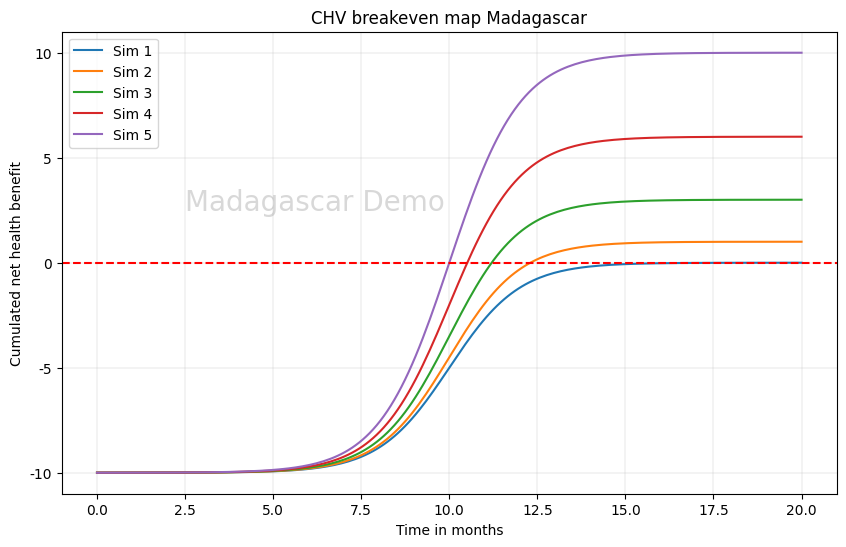

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x, l1, label="Sim 1")
plt.plot(x, l2, label="Sim 2")
plt.plot(x, l3, label="Sim 3")
plt.plot(x, l4, label="Sim 4")
plt.plot(x, l5, label="Sim 5")
plt.grid(axis="both", lw=.2)
plt.title("CHV breakeven map Madagascar")
plt.ylabel("Cumulated net health benefit")
plt.xlabel("Time in months")
plt.yticks(np.linspace(0,20,5), labels=[-10, -5, 0, 5, 10])
plt.axhline(10, c="r", ls="--")
plt.text(2.5, 12.5, "Madagascar Demo", color="gray", alpha=.3, fontsize=20)
plt.legend()
#plt.savefig("/Users/wobiero/Desktop/mada_chv.png", bbox_inches="tight")

In [ ]:
pwd

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd "/content/gdrive/MyDrive/Colab Notebooks"

/content/gdrive/MyDrive/Colab Notebooks


In [ ]:
!jupyter nbconvert --to html "mada_mccm.ipynb"

[NbConvertApp] Converting notebook mada_mccm.ipynb to html
[NbConvertApp] Writing 900570 bytes to mada_mccm.html
